### 1. Analytical solution

Equation: $$\frac{d}{dx}\left(k\frac{dT}{dx}\right) + q =0$$

Boundary conditions:
Initial condition: $T(0)= T_A$ 
Insulated condition: $T'(L)=0$ - no flux throw the boundary


Solving analytically 
$$k\frac{dT}{dx} =- qx+C$$
$$T =-\frac{qx^2}{2k}+C_1x+C_2$$

Applying Boundary conditions
$$T(0)=C_2=T_A$$
$$T'(L)=\frac{-qL}{k}+C_1=0 \Rightarrow C_1=\frac{qL}{k}$$

Analytical solution: $$T(x)=-\frac{qx^2}{2k}+\frac{qL}{k}x+T_A$$

In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
#Data
np.random.seed(10)
TA=120
k=0.6
q=500
startpoint=0
L=0.16 #meters
# n=3# number of points; 4 control volumes
n=11 # number of points; 12 control volumes
# n=19 # number of points; 20
# n=35 # number of points; 36
# n=100
h=(L-startpoint)/n

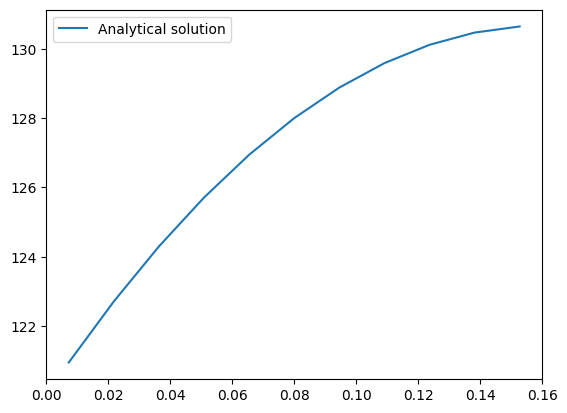

In [74]:
c1= q * L / k
c2=TA
x=np.linspace(startpoint,L-h,n) + h/2 
T= -q * x * x / (2*k) + c1 * x + c2
plt.plot(x,T,label="Analytical solution")
plt.legend()
plt.show()

### 2. Discretisation of the equation

![discretisation](discretisation.jpg)

Coefficients:
$$aE_i=aW_i=\frac{k}{\delta x}$$
$$S=S_P\phi_P +S_U$$
$$\phi=T$$
$$S_U=q=C_i$$
$$S_P=0$$
$$a_P = a_W + a_E − S_P$$

In [64]:
import sympy as sp
import IPython.display as disp

sp.init_printing(use_latex='mathjax',use_unicode=True) 
matrix=sp.symarray(0, (n,n))

for i in range(n):
    for j in range(n):
        if j==i-1:
            matrix[i][j]=sp.symbols(f"-aW_{i}")
        elif j==i:
            matrix[i][j]=sp.symbols(f"aP_{i}")
        elif j==i+1:
            matrix[i][j]=f"-aE_{i}" 
        else:
            matrix[i][j]=0
            

matrix=sp.Matrix(matrix)
C_matrix=sp.symarray("C", n)
C_matrix=sp.Matrix(C_matrix)

disp.display(disp.Math(sp.latex(matrix) +"=" +sp.latex(C_matrix)))

<IPython.core.display.Math object>

In [65]:
#System of linear equations
aP=np.zeros(n)
aW=np.zeros(n)
aE=np.zeros(n)
S=np.zeros(n)

# M*phi=Su
M=np.zeros((n,n))
for i in range(1,n-1):
    # if (i!=0) & (i!=n-1):
    aW[i]=k/h
    aE[i]=k/h
    aP[i]=aW[i]+aE[i] #Sp=0
    M[i,i-1]=-aW[i]
    M[i,i]=aP[i]
    M[i,i+1]=-aE[i]
    S[i]=q*h
    
    
#Boundaries
M[0][0]=k/h+2*k/h
M[0][1]=-k/h
S[0]=TA*2*k/h+q*h

M[n-1][n-1]=k/h
M[n-1][n-2]=-k/h
S[n-1]=q*h

print(M)
print(S)

[[123.75 -41.25   0.     0.     0.     0.     0.     0.     0.     0.
    0.  ]
 [-41.25  82.5  -41.25   0.     0.     0.     0.     0.     0.     0.
    0.  ]
 [  0.   -41.25  82.5  -41.25   0.     0.     0.     0.     0.     0.
    0.  ]
 [  0.     0.   -41.25  82.5  -41.25   0.     0.     0.     0.     0.
    0.  ]
 [  0.     0.     0.   -41.25  82.5  -41.25   0.     0.     0.     0.
    0.  ]
 [  0.     0.     0.     0.   -41.25  82.5  -41.25   0.     0.     0.
    0.  ]
 [  0.     0.     0.     0.     0.   -41.25  82.5  -41.25   0.     0.
    0.  ]
 [  0.     0.     0.     0.     0.     0.   -41.25  82.5  -41.25   0.
    0.  ]
 [  0.     0.     0.     0.     0.     0.     0.   -41.25  82.5  -41.25
    0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.   -41.25  82.5
  -41.25]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.   -41.25
   41.25]]
[9.90727273e+03 7.27272727e+00 7.27272727e+00 7.27272727e+00
 7.27272727e+00 7.27272727e+00 7.27272727e+00 7.27272

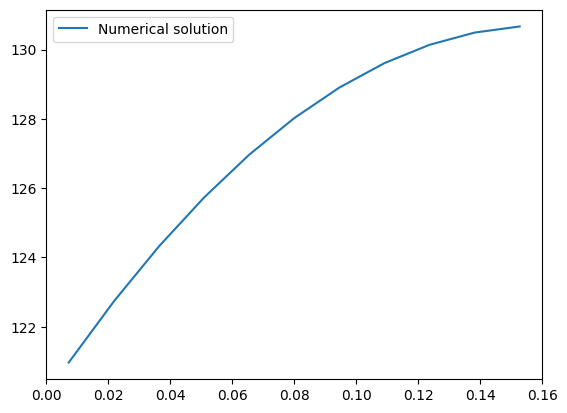

In [66]:
phi_system=np.linalg.solve(M, S)
plt.plot(x, phi_system, label="Numerical solution")
plt.legend()
plt.show()

In [67]:
print("MSE of numpy and analytical solution: ",((phi_system - T) * (phi_system - T)).sum() / n)
# print(phi_system)
# print(T)

MSE of numpy and analytical solution:  0.0004856984571457891


### 3. TDMA solution
### 4. Comparing TDMA solution with numpy methods

![TDMA](TDMA_system.jpg)

![TDMA](TDMA_general.jpg)

![TDMA_sol](TDMA_solution.jpg)

$$aW_i=\beta_i$$
$$aE_i=\alpha_i$$
$$aP_i=D_i$$

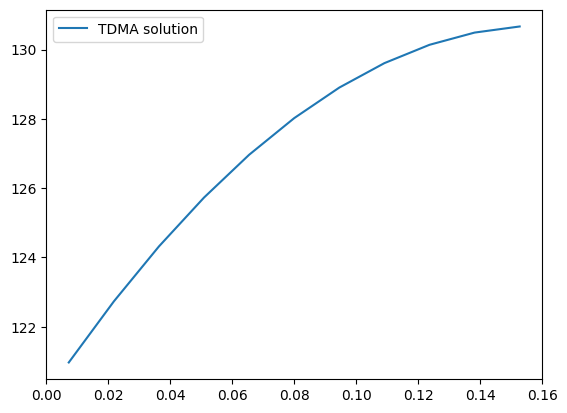

MSE of TDMA and analytical solution: 0.0004856984571464155
Average percentage error of TDMA and analytical solution: 0.00017347951153367938
MSE of numpy and TDMA solution: 3.855378387698327e-28


In [68]:
#TDMA
a=-np.concatenate([np.array([M[i,i+1] for i in range(n-1)]),np.array([0])])
b=-np.concatenate([np.array([0]),np.array([M[i,i-1] for i in range(1,n)])])
D=np.array([M[i,i] for i in range(n)])
C=S.copy()

A=np.zeros(n-1)
C_h=np.zeros(n-1)
A[0]=a[0]/D[0]
C_h[0]=C[0]/D[0]
for i in range(1,n-1):
    A[i]=a[i]/(D[i]-b[i]*A[i-1])
    C_h[i]=(b[i]*C_h[i-1]+C[i])/(D[i]-b[i]*A[i-1])

phi_TDMA=np.zeros(n)
phi_TDMA[n - 1]= (C[n - 1] + C_h[n - 2] * b[n - 1]) / (D[n - 1] - b[n - 1] * A[n - 2])
for i in reversed(range(n-1)):
    phi_TDMA[i]=A[i]*phi_TDMA[i+1]+C_h[i]
    
plt.plot(x, phi_TDMA, label="TDMA solution")
plt.legend()
plt.show()

print("MSE of TDMA and analytical solution:",((phi_TDMA - T) * (phi_TDMA - T)).sum() / n)
print("Average percentage error of TDMA and analytical solution:", (np.abs(phi_TDMA - T)/T).sum() / n)
print("MSE of numpy and TDMA solution:", ((phi_TDMA - phi_system) * (phi_TDMA - phi_system)).sum() / n)

We can see that obtained by TDMA solution is quite close to the analytical solution. The average percentage error is less than 1%. Also we can see that obtained by TDMA solution of the system is very close to the numpy solution. MSE error is about $10^{-26}$

### 5. Error between analytical and TDMA solution at $x=14$ with dividing domain in $12,20,36$ control volumes. 

In [69]:
# Errors with different number of points for closest value to x=14.
# print(T[x[14]])
x_test=0.14
idx_x=np.abs(x-x_test).argmin()
print(abs(T[idx_x]-phi_TDMA[idx_x]))

0.022038567493012806


In [70]:
local_errors=[0.022038567493012806,0.007386888273231307,0.0021768707477747284]
global_TDMA_MSE_errors=[0.0004856984571464155,5.456611836158894e-05 ,4.738766253434755e-06]
volumes=[12,20,36]

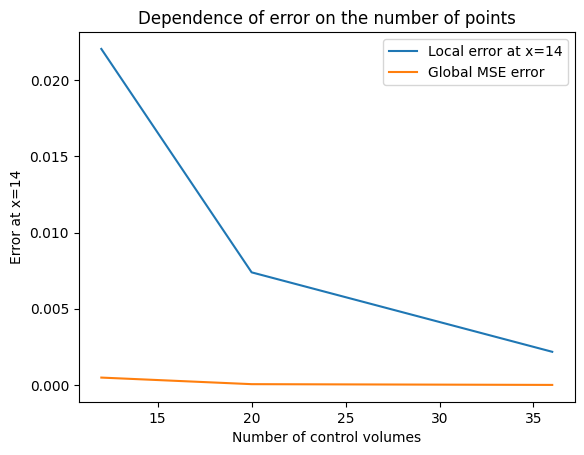

In [71]:
plt.plot(volumes,local_errors,label="Local error at x=14")
plt.plot(volumes,global_TDMA_MSE_errors,label= "Global MSE error")
plt.legend()
plt.title("Dependence of error on the number of points")
plt.xlabel("Number of control volumes")
plt.ylabel("Error at x=14")
plt.show()

We see that the local error (as well as the global error) decreases with the increase of the number of control volumes and tends to zero. Which can show that our numerical solution is correct and quite efficient.